# GUI: From meshing to fitting 

## Mesh — 1D Gmsh Mesh Generator

This is an **`GUI** for generating 1D meshes with Gmsh, wrapping the `OneDSampleMeshGenerator` class.

### Key Features:
* **Mesh Configuration:** Define mesh length and specify element spacing by either the total **number of divisions** or a target **mesh size**.
* **File Output:** Set a sanitized filename and toggle overwrite protection. The UI shows a live preview of the final save path.
* **Controls:** Buttons to **Generate** the mesh, **Preview** it with a plot, and **Reset** the form.
* **User Feedback:** A progress bar, color-coded status indicator, and a log area provide real-time updates and error tracebacks.


In [1]:

import sys
sys.path.append("../sources")
from mesh_gui import MeshGUI
# Launch the UI
mesh_app = MeshGUI()  
mesh_app.show()


The function that prints a formatted summary of the current settings from the mesh_app.

In [2]:
import pandas as pd
from IPython.display import display

def print_mesh_summary(mesh_app):
    """
    Print key parameters from the MeshGUI configuration.
    Displays a styled DataFrame for a high-end look.
    """
    
    # 1. Access widgets dictionary
    w = mesh_app.widgets
    
    # 2. Get Filename (handle empty logic same as GUI)
    fname = w['filename'].value.strip() or mesh_app.default_mesh_basename
    
    # 3. Base Parameters
    data = {
        "Configuration Item": [
            "Output Directory",
            "File Name",
            "Sample Length",
            "Physical Tag: Upstream",
            "Physical Tag: Downstream",
            "Physical Tag: Sample"
        ],
        "Value": [
            mesh_app.output_dir,
            f"{fname}.msh",
            f"{w['length'].value} m",
            "3", # Fixed tag
            "4", # Fixed tag
            "5"  # Fixed tag
        ]
    }

    # 4. Mode-specific Logic
    mode = w['mode'].value
    if mode == "div":
        data["Configuration Item"].append("Discretization Mode")
        data["Value"].append("By Divisions")
        
        data["Configuration Item"].append("Number of Divisions")
        data["Value"].append(str(w['num_div'].value))
    else: # "size"
        data["Configuration Item"].append("Discretization Mode")
        data["Value"].append("By Mesh Size")
        
        data["Configuration Item"].append("Target Element Size")
        data["Value"].append(f"{w['mesh_size'].value} m")

    # 5. Create DataFrame
    df = pd.DataFrame(data)

    # 6. Display with Style
    print("\n")
    # Styling: Left align, hide index, add a subtle background to headers
    styled_df = df.style.hide(axis="index").set_properties(**{
        'text-align': 'left',
        'font-family': 'Segoe UI, sans-serif',
        'border-color': '#e1e4e8'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'), ('background-color', '#f4f6f9'), ('color', '#2c3e50')]},
        {'selector': 'td', 'props': [('padding', '8px 12px')]}
    ]).set_caption("<b>MESH GENERATION CONFIGURATION SNAPSHOT</b>")
    
    display(styled_df)

# Run the summary
print_mesh_summary(mesh_app)

Configuration Item,Value
Output Directory,./gmsh
File Name,sample_1D.msh
Sample Length,0.005 m
Physical Tag: Upstream,3
Physical Tag: Downstream,4
Physical Tag: Sample,5
Discretization Mode,By Divisions
Number of Divisions,20


## Diffusion Experiment Analysis GUI Tool Documentation

This tool provides a comprehensive GUI within a Jupyter Notebook environment for setting up, running, and visualizing diffusion experiments. It is designed to analyze both **"through-diffusion"** and **"out-diffusion"** scenarios by fitting experimental data to a numerical model provided by the `ADE_DG` backend.

The application is built using a modular, class-based structure that separates concerns:
- **`DiffusionGUI`**: Manages the user interface, input parameters, and data loading.
- **`ThroughDiffusionFitter` / `OutDiffusionFitter`**: Handle the numerical optimization and parameter fitting using `lmfit`.
- **`DiffusionPlotter`**: Visualizes the comparison between experimental data and the fitted model.
- **Reporting**: Generates a standalone HTML report that archives the parameters, fit results, and plots for traceability.


In [3]:
# === Standard Library ===
import os
import sys
import io
import json
import base64
import html
import contextlib
import traceback
from pathlib import Path
import datetime

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import lmfit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.integrate as integrate
import ipywidgets as widgets
from ipyfilechooser import FileChooser
from IPython.display import display, clear_output

# === Local Modules ===
sys.path.append("../sources")
import ADE_DG  # local module


### `DiffusionGUI` Class
This is the main class that constructs and controls the interactive user interface using `ipywidgets`.

**Key Responsibilities:**
- **`__init__()`**: Initializes the application, sets up widgets, layout, and event handlers, and attempts to auto-load the last saved state.
- **`_setup_widgets()`**: Creates all the interactive elements, including:
    - `ToggleButtons` for selecting the experiment mode (`Through-diffusion` vs. `Out-diffusion`).
    - `FileChooser` widgets for selecting the experimental data file (Excel/ODS) and the mesh file (`.msh`).
    - `FloatText` and `IntText` for inputting physical parameters (e.g., thickness, area), solver settings (e.g., `tol`), and initial guesses for fitting parameters (`alpha`, `De`).
    - `Button` widgets to trigger actions like preparing the problem, saving, and loading settings.
- **`_setup_layout()`**: Arranges the widgets into a clean, logical layout using `HBox` and `VBox` containers.
- **`save_state()` / `load_state()`**: Provides persistence by saving the current GUI state (file paths, parameters) to a JSON file (`.diffusion_gui_state.json`) and loading it back. Settings are also auto-saved when a problem is prepared.
- **`_load_in_diffusion_data()` / `_load_out_diffusion_data()`**: Handles the loading and preprocessing of experimental data from specified Excel/ODS sheets. It converts time units from days to seconds and structures the data into NumPy arrays for the fitting process.
- **`on_prepare()`**: This is the primary action button's callback. It:
    1.  Logs all user-defined parameters for traceability.
    2.  Loads the relevant experimental data based on the selected mode.
    3.  Initializes the `ADE_DG` simulation object with the mesh, geometry markers, and initial parameter guesses.
    4.  Prepares the backend for the fitting step.


In [4]:
import sys
import json
import datetime
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate 
import ipywidgets as widgets
from ipywidgets import Layout, HBox, VBox, HTML, GridBox
from ipyfilechooser import FileChooser
from pathlib import Path
from IPython.display import display, clear_output

# Ensure your custom sources are importable
sys.path.append("../sources")

# Mock import for demonstration if ADE_DG is missing
try:
    import ADE_DG
except ImportError:
    class ADE_DG:
        class ADE_DG:
            def __init__(self, mesh, deg): pass
            def set_porosity(self, d): pass
            def set_De(self, d): pass

class DiffusionGUI:
    DAY_TO_SEC = 24 * 3600

    # --- STYLE DEFINITIONS ---
    STYLE_CSS = """
    <style>
        .app-container { font-family: 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; background-color: #f8f9fa; padding: 15px; border-radius: 8px; }
        
        /* Card Styling */
        .card { background-color: #ffffff; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.05); padding: 15px; margin-bottom: 15px; border: 1px solid #e9ecef; }
        .card-header { font-size: 15px; font-weight: 700; color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 6px; margin-bottom: 12px; }
        
        /* Typography */
        .section-label { font-size: 12px; font-weight: 700; color: #7f8c8d; margin-bottom: 4px; text-transform: uppercase; letter-spacing: 0.5px; }
        .main-title { font-size: 22px; font-weight: 800; color: #2c3e50; margin: 0; }
        .sub-title { font-size: 13px; color: #7f8c8d; margin-top: 2px; }
        
        /* Console */
        .console-box { background-color: #2c3e50; color: #1abc9c; font-family: 'Consolas', monospace; padding: 10px; border-radius: 6px; font-size: 11px; line-height: 1.4; }
    </style>
    """

    def __init__(self):
        self._setup_widgets()
        self._setup_layout()
        self._bind_events()

        # runtime state
        self.mode = "Through"
        self.side = self.widgets['side_selector'].value
        self.fitter = None
        self.problem = None
        self.params_gui = None

        # try autoload settings
        try:
            self.load_state(silent=True)
        except Exception:
            pass

    # ---------- widgets ----------
    def _create_widget(self, w_type, description, value, **kwargs):
        kwargs.setdefault('style', {'description_width': 'initial'})
        kwargs.setdefault('layout', Layout(width='96%')) 
        return w_type(value=value, description=description, **kwargs)

    def _setup_widgets(self):
        self.widgets = {
            # --- Control Widgets ---
            'exp_mode': widgets.ToggleButtons(
                options=["Through-diffusion", "Out-diffusion"],
                description="",
                style={'button_width': '170px', 'font_weight': 'bold'},
                layout=Layout(width='auto', margin='0 0 10px 0')
            ),
            'side_selector': widgets.ToggleButtons(
                options=[('Upstream', 'upstream'), ('Downstream', 'downstream'), ('Both', 'both')],
                value='both', 
                description='',
                button_style='info',
                style={'button_width': '120px'},
                layout=Layout(width='auto')
            ),
            
            # --- File Inputs ---
            'file_chooser': FileChooser("./", title='', filter_pattern=['*.xlsx', '*.ods']),
            'file_path_text': widgets.Text(placeholder="Select Data File...", disabled=True, layout=Layout(width='98%')),
            'mesh_chooser': FileChooser("./gmsh", title='', filter_pattern=['*.msh']),
            'mesh_path_text': widgets.Text(placeholder="Select Mesh File...", disabled=True, layout=Layout(width='98%')),

            # --- Geometry ---
            'sample_marker': self._create_widget(widgets.IntText, "Sample ID", 5),
            'upstream_marker': self._create_widget(widgets.IntText, "Upstream ID", 3),
            'downstream_marker': self._create_widget(widgets.IntText, "Downstream ID", 4),
            'thickness': self._create_widget(widgets.FloatText, "Thickness (m)", 5e-3),
            'area': self._create_widget(widgets.FloatText, "Area (m²)", 0.196e-4),

            # --- Physics ---
            'alpha': self._create_widget(widgets.FloatText, "Init. Porosity (α)", 0.45),
            'De': self._create_widget(widgets.FloatText, "Init. De (m²/s)", 2.5e-12),
            'tol': self._create_widget(widgets.FloatText, "Tolerance", 1e-3),
            
            # Hidden dt widget (Logic retained, UI removed)
            'dt': self._create_widget(widgets.FloatText, "Time step dt (s)", 1000.0),

            # --- Actions ---
            'prepare_btn': widgets.Button(
                description="PREPARE PROBLEM", 
                button_style='primary',
                layout=Layout(width='100%', height='45px', font_weight='bold', margin='10px 0'),
                icon='cube'
            ),
            'save_btn': widgets.Button(description="Save", icon='save', layout=Layout(width='48%')),
            'load_btn': widgets.Button(description="Load", icon='folder-open', layout=Layout(width='48%')),
            
            # --- Outputs ---
            'prepare_output': widgets.Output(layout=Layout(width='100%', height='120px', overflow='auto')),
            'results_output': widgets.Output(layout=Layout(width='100%', height='auto')), 
        }
        
        # Adjust Chooser Styles
        self.widgets['file_chooser'].use_dir_icons = True
        self.widgets['mesh_chooser'].use_dir_icons = True
        
        self.side_row = VBox([
            HTML("<div class='section-label'>Fitting Side</div>"),
            self.widgets['side_selector']
        ])
        self.side_row.layout.display = 'none'

    def _setup_layout(self):
        w = self.widgets

       # 1. Header Section
        header = HTML(f"""
        {self.STYLE_CSS}
        <div style="display: flex; align-items: center; justify-content: space-between; margin-bottom: 20px;">
            <div>
                <h1 class="main-title">Diffusion<span style="color:#3498db">Analysis</span> Platform</h1>
                <div class="sub-title">Advanced parameter estimation & simulation environment</div>
            </div>
            <div style="text-align: right; color: #95a5a6; font-size: 12px;">
                v2.1 Pro | Powered by IPyWidgets
            </div>
        </div>
        """)

        # --- LEFT SIDEBAR (Controls) ---
        
        # Section 1: Setup
        box_setup = VBox([
            HTML("<div class='section-label'>Experiment Mode</div>"),
            w['exp_mode'],
            self.side_row
        ], layout=Layout(margin='0 0 15px 0'))

        # Section 2: Files
        def make_file_compact(icon, chooser, text, hint):
            return VBox([
                HBox(
                    [HTML(f"<b style='color:#34495e; margin-right:5px'>{icon}</b>"), chooser],
                    layout=Layout(align_items='center')
                ),
                text,
                HTML(f"<div style='font-size:11px; color:#7f8c8d; margin-top:2px'>{hint}</div>")
            ], layout=Layout(margin='0 0 10px 0'))


        box_files = VBox([
            HTML("<div class='card-header'>1. Data Sources</div>"),
            make_file_compact(
                "📊",
                w['file_chooser'],
                w['file_path_text'],
                "Experimental Data (.xlsx / .ods)"
            ),
            make_file_compact(
                "🕸️",
                w['mesh_chooser'],
                w['mesh_path_text'],
                "Finite Element Mesh (.msh)"
            ),
        ], layout=Layout(classes='card'))


        # Section 3: Parameters
        grid_geo = GridBox([
            w['sample_marker'], w['upstream_marker'], 
            w['downstream_marker'], w['thickness'], 
            w['area']
        ], layout=Layout(grid_template_columns='repeat(2, 1fr)', grid_gap='5px'))

        grid_phys = GridBox([
            w['alpha'], w['De'], w['tol']
        ], layout=Layout(grid_template_columns='repeat(2, 1fr)', grid_gap='5px'))

        box_params = VBox([
            HTML("<div class='card-header'>2. System Parameters</div>"),
            HTML("<div class='section-label'>Geometry & Mesh IDs</div>"),
            grid_geo,
            HTML("<div class='section-label' style='margin-top:10px'>Physics & Solver</div>"),
            grid_phys
        ], layout=Layout(classes='card'))

        # Section 4: Execute & Log
        box_actions = VBox([
            HTML("<div class='card-header'>3. Execution</div>"),
            w['prepare_btn'],
            HBox([w['save_btn'], w['load_btn']], layout=Layout(justify_content='space-between')),
            HTML("<div class='section-label' style='margin-top:10px'>System Log</div>"),
            VBox([w['prepare_output']], layout=Layout(classes='console-box'))
        ], layout=Layout(classes='card'))

        # --- LEFT SIDEBAR LAYOUT (32%) ---
        left_sidebar = VBox([
            box_setup, 
            box_files, 
            box_params, 
            box_actions
        ], layout=Layout(width='50%', min_width='340px', margin='0 20px 0 0'))

        # --- RIGHT MAIN AREA (Visualization) (68%) ---
        with w['results_output']:
            display(HTML("""
            <div class='card' style='height: 800px; display:flex; align-items:center; justify-content:center; background-color: white;'>
                <div style='text-align:center; color:#bdc3c7'>
                    <div style='font-size: 60px;'>📊</div>
                    <div style='font-size: 20px; font-weight:bold; margin-top:10px'>Data Dashboard</div>
                    <div style='font-size: 14px;'>Awaiting Data...</div>
                </div>
            </div>
            """))

        right_dashboard = VBox([
            w['results_output']
        ], layout=Layout(width='50%'))


        # --- ASSEMBLY ---
        main_content = HBox([left_sidebar, right_dashboard], layout=Layout(align_items='flex-start', width='100%'))
        
        self.ui = VBox([
            header,
            main_content
        ], layout=Layout(classes='app-container', width='100%'))

    def _bind_events(self):
        self.widgets['exp_mode'].observe(self._on_mode_change, names='value')
        self.widgets['side_selector'].observe(lambda ch: setattr(self, "side", ch.new), names='value')
        
        def update_file_path(chooser):
            self.widgets['file_path_text'].value = chooser.selected or ""
        self.widgets['file_chooser'].register_callback(update_file_path)

        def update_mesh_path(chooser):
            self.widgets['mesh_path_text'].value = chooser.selected or ""
        self.widgets['mesh_chooser'].register_callback(update_mesh_path)

        self.widgets['prepare_btn'].on_click(self.on_prepare)
        self.widgets['save_btn'].on_click(lambda _: self.save_state())
        self.widgets['load_btn'].on_click(lambda _: self.load_state())

    # ---------- JSON settings ----------
    def _state_path(self): return Path(".diffusion_gui_state.json")

    def _gather_state(self):
        w = self.widgets
        params = {name: widget.value for name, widget in w.items()
                  if isinstance(widget, (widgets.FloatText, widgets.IntText, widgets.Dropdown))}
        return {
            "mode": self.mode,
            "side": self.side,
            "file_path": w['file_path_text'].value,
            "mesh_path": w['mesh_path_text'].value,
            "params": params,
            "timestamp": datetime.datetime.now().isoformat(),
        }

    def _apply_state(self, state):
        if not state: return
        w = self.widgets
        self.mode = state.get("mode", self.mode)
        w['exp_mode'].value = "Out-diffusion" if self.mode == "out" else "Through-diffusion"
        self.side = state.get("side", self.side)
        w['side_selector'].value = self.side if self.side in ("upstream", "downstream", "both") else "both"
        
        f_path = state.get("file_path", "")
        m_path = state.get("mesh_path", "")
        w['file_path_text'].value = f_path
        w['mesh_path_text'].value = m_path
        if f_path: w['file_chooser'].default_path = str(Path(f_path).parent)
        if m_path: w['mesh_chooser'].default_path = str(Path(m_path).parent)

        for k, v in state.get("params", {}).items():
            if k in w and hasattr(w[k], "value"):
                try: w[k].value = v
                except: pass

    def save_state(self, path=None, silent=False):
        path = Path(path) if path else self._state_path()
        try:
            path.write_text(json.dumps(self._gather_state(), ensure_ascii=False, indent=2))
            if not silent:
                with self.widgets['prepare_output']:
                    print(f"✓ Settings saved to: {path.resolve()}")
        except Exception as e:
            if not silent: print(f"Save failed: {e}")

    def load_state(self, path=None, silent=False):
        path = Path(path) if path else self._state_path()
        if not path.exists():
            if not silent:
                with self.widgets['prepare_output']:
                    print("⚠️ No saved settings found.")
            return
        try:
            self._apply_state(json.loads(path.read_text()))
            if not silent:
                with self.widgets['prepare_output']:
                    print(f"✓ Settings loaded from: {path.resolve()}")
        except Exception as e:
            with self.widgets['prepare_output']:
                print(f"❌ Failed to load settings: {e}")

    # ---------- Data loaders ----------
    def _load_Through_diffusion_data(self, file_path):
        Cusb = pd.read_excel(file_path, sheet_name="Cusb", header=0, skiprows=[1])
        Jdsb = pd.read_excel(file_path, sheet_name="Jdsb", header=0, skiprows=[1])
        Makk = pd.read_excel(file_path, sheet_name="Makk", header=0, skiprows=[1])

        for df in (Cusb, Jdsb, Makk):
            df.columns = df.columns.str.strip()
            if 'Time' in df.columns:
                df['Time'] *= self.DAY_TO_SEC

        self.tdat = np.array(Jdsb['Time'])
        self.fdat = np.array(Jdsb['JL'])
        self.fdatU = np.where(np.array(Jdsb['U(JL)']) == 0, 1e-20, np.array(Jdsb['U(JL)']))
        self.tudat = np.array(Cusb['Time'])
        self.cudat = np.array(Cusb['Cusb'])
        self.cudatU = np.where(np.array(Cusb['U(Cusb)']) == 0, 1e-20, np.array(Cusb['U(Cusb)']))
        self.t_down_rest = np.array(Makk['Time'])
        self.upstream_volume = float(Cusb['Vhigh'][0]) * 1e-6
        self.downstream_volume = float(Jdsb['Vlow'][0]) * 1e-6
        self.upstream_concentration = float(Cusb['Cusb'][0])
        self.normalization_factor = self.upstream_concentration if self.upstream_concentration != 0 else 1.0
    def _load_out_diffusion_data(self, file_path):
        engine = 'odf' if str(file_path).lower().endswith('.ods') else None
        exp = pd.read_excel(file_path, header=0, skiprows=[1], engine=engine)
        exp.columns = exp.columns.str.strip()
        if 'time_hi' in exp.columns: exp['time_hi'] *= self.DAY_TO_SEC
        if 'time_lo' in exp.columns: exp['time_lo'] *= self.DAY_TO_SEC

        self.out_t_hi = np.array(exp.get('time_hi', []))
        self.out_flux_hi = np.array(exp.get('Flux_Hi', []))
        self.out_uFlux_hi = np.where(np.array(exp.get('uFlux_Hi', [])) == 0, 1e-20, np.array(exp.get('uFlux_Hi', [])))
        self.out_t_lo = np.array(exp.get('time_lo', []))
        self.out_flux_lo = np.array(exp.get('Flux_Lo', []))
        self.out_uFlux_lo = np.where(np.array(exp.get('Uflux_Lo', [])) == 0, 1e-20, np.array(exp.get('Uflux_Lo', [])))

    # ---------- Visualization (High-End Professional Style) ----------
    def _visualize_data(self):
        """Generates Publication-Quality Plots in the Right Dashboard."""
        out = self.widgets['results_output']
        
        with out:
            clear_output(wait=True)
            
            # --- High-End Styling Constants ---
            # Colors
            C_FLUX  = '#2C3E50'  # Deep Charcoal/Blue
            C_CUM   = '#C0392B'  # Brick Red
            C_UP    = '#D35400'  # Pumpkin
            C_DOWN  = '#2980B9'  # Strong Blue
            C_GRID  = '#ECF0F1'  # Very light gray
            
            # Font & Line Settings
            FONT_TITLE = {'family': 'sans-serif', 'weight': 'bold', 'size': 14, 'color': '#2c3e50'}
            FONT_LABEL = {'family': 'sans-serif', 'weight': 'bold', 'size': 11, 'color': '#34495e'}
            SPINE_WIDTH = 2.0
            # Marker with white border for clean look
            MARKER_STYLE = dict(markersize=8, markeredgecolor='white', markeredgewidth=1.5, zorder=10)
            
            def style_axis(ax, title, xlabel, ylabel):
                # Title & Labels
                ax.set_title(title, loc='left', pad=15, **FONT_TITLE)
                ax.set_xlabel(xlabel, labelpad=8, **FONT_LABEL)
                ax.set_ylabel(ylabel, labelpad=8, **FONT_LABEL)
                
                # Grid (Behind data)
                ax.grid(True, linestyle='--', color=C_GRID, linewidth=1.5, zorder=0)
                
                # Spines (Borders) - Thicker
                for spine in ['left', 'bottom']:
                    ax.spines[spine].set_linewidth(SPINE_WIDTH)
                    ax.spines[spine].set_color('#333333')
                for spine in ['top', 'right']:
                    ax.spines[spine].set_visible(False)
                
                # Ticks - Thicker
                ax.tick_params(axis='both', which='major', width=SPINE_WIDTH, length=6, labelsize=10, colors='#333333')
                
                # Legend - Floating shadow box
                if ax.get_legend():
                    ax.legend(frameon=True, framealpha=0.9, edgecolor='#bdc3c7', fontsize=10, fancybox=True, shadow=True)

            # --- Start Plotting ---
            
            # 1. Through-Diffusion Mode (Vertical Stack)
            if self.mode == 'Through':
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 7), dpi=120, layout='constrained')
                
                # Data
                t = self.tdat
                y = self.fdat
                y_err = self.fdatU
                
                # Cumulative Calc
                sort_idx = np.argsort(t)
                t_sorted = t[sort_idx]
                y_sorted = y[sort_idx]
                y_cum = integrate.cumulative_trapezoid(y_sorted, t_sorted, initial=0)
                
                if len(t) > 0:
                    # Plot 1: Flux (Errorbar)
                    ax1.errorbar(t, y, yerr=y_err, fmt='o', 
                                 color=C_FLUX, ecolor='#95a5a6', elinewidth=2, capsize=4, capthick=2,
                                 label='Experimental Flux', **MARKER_STYLE)
                    
                    style_axis(ax1, 
                               title="Downstream Flux Rate", 
                               xlabel="Time (s)", 
                               ylabel=r"Flux ($mol \cdot m^{-2} \cdot s^{-1}$)")
                    
                    # Plot 2: Cumulative (Connected Lines + Fill)
                    ax2.plot(t_sorted, y_cum, 'o', 
                             color=C_CUM, linewidth=2.5, label='Cumulative Amount', **MARKER_STYLE)
                    # Add atmospheric fill
                    ax2.fill_between(t_sorted, y_cum, alpha=0.1, color=C_CUM)
                    
                    style_axis(ax2, 
                               title="Cumulative Mass Transfer", 
                               xlabel="Time (s)", 
                               ylabel=r"Cumulative Flux ($mol \cdot m^{-2}$)")
                    
                else:
                    ax1.text(0.5, 0.5, "No Data Loaded", ha='center', fontsize=14, color='#bdc3c7')
                    ax1.axis('off')
                    ax2.axis('off')

            # 2. Out-Diffusion Mode (Single Large Plot)
            else:
                fig, ax = plt.subplots(figsize=(8, 5), dpi=120, layout='constrained')
                
                t_hi = self.out_t_hi
                y_hi = self.out_flux_hi
                t_lo = self.out_t_lo
                y_lo = self.out_flux_lo
                
                if len(t_hi) > 0 or len(t_lo) > 0:
                    # Upstream
                    ax.semilogy(t_hi, y_hi, 'o', color=C_UP, label='Upstream Reservoir', alpha=0.9, **MARKER_STYLE)
                    # Downstream
                    ax.semilogy(t_lo, y_lo, 'o', color=C_DOWN, label='Downstream Reservoir', alpha=0.9, **MARKER_STYLE)
                    
                    style_axis(ax, 
                               title="Out-Diffusion Flux Decay", 
                               xlabel="Time (s)", 
                               ylabel=r"Flux ($mol \cdot m^{-2} \cdot s^{-1}$)")
                    
                    # Extra styling for Log Scale
                    ax.grid(True, which="minor", ls=":", alpha=0.4, color=C_GRID)
                    
                else:
                    ax.text(0.5, 0.5, "No Data Loaded", ha='center', fontsize=14, color='#bdc3c7')
                    ax.axis('off')

            plt.show()

    # ---------- main ----------
    def on_prepare(self, _):
        out = self.widgets['prepare_output']
        with out:
            clear_output(wait=True)

            file_path = self.widgets['file_path_text'].value
            mesh_path = self.widgets['mesh_path_text'].value
            if not file_path or not mesh_path:
                print("⚠️ Please select Data and Mesh files.")
                return

            def log(line=""):
                print(line)

            log(f"▶ PREPARING: {self.mode.upper()}")
            
            p = {name: widget.value for name, widget in self.widgets.items()
                 if isinstance(widget, (widgets.FloatText, widgets.IntText, widgets.Dropdown))}
            self.params_gui = p

            try:
                if self.mode == 'Through':
                    self._load_Through_diffusion_data(file_path)
                else:
                    self._load_out_diffusion_data(file_path)

                log("• Building Finite Element Problem...")
                DEFAULT_DEG = 2 
                self.problem = ADE_DG.ADE_DG(mesh_path, deg=DEFAULT_DEG)
                self.problem.set_porosity({p['sample_marker']: p['alpha']})
                self.problem.set_De({p['sample_marker']: p['De']})
                
                log("✓ Ready.")
                self.save_state(silent=True)
                
                # --- TRIGGER VISUALIZATION ---
                self._visualize_data()

            except Exception as e:
                log(f"❌ Error: {e}")
                # traceback.print_exc()

    # ---------- handlers ----------
    def _on_mode_change(self, change):
        is_out = change.new == "Out-diffusion"
        self.side_row.layout.display = '' if is_out else 'none'
        self.mode = "out" if is_out else "Through"

    def display(self):
        display(self.ui)


# Bootstrap
if __name__ == '__main__':
    app = DiffusionGUI()
    app.display()

### `ThroughDiffusionFitter` and `OutDiffusionFitter` Classes
These classes contain the logic for fitting the model to the experimental data. A specific class is chosen based on the experiment mode.

**Key Responsibilities:**
- **`__init__()`**: Initializes the fitter with the prepared `problem` object and all necessary parameters from the `DiffusionGUI` instance.
- **`objective(params)`**: The core function for the optimization process. It:
    1.  Takes a set of parameters (`alpha`, `De`) from `lmfit`.
    2.  Updates the `ADE_DG` problem with these parameters.
    3.  Runs the simulation (`problem.solve_adaptive_timesteps()`).
    4.  Calculates the residuals (differences) between the simulated output (e.g., flux, concentration) and the experimental data. For out-diffusion, this is done in log-space.
    5.  Returns the residuals for the minimizer.
- **`fit()`**:
    1.  Sets up the fitting parameters in an `lmfit.Parameters` object, defining their initial values and bounds.
    2.  Creates an `lmfit.Minimizer` instance with the `objective` function.
    3.  Runs the minimization algorithm (`leastsq`) to find the best-fit values for `alpha` and `De`.
    4.  Prints a detailed fit report and stores the final result object.
- **`run_model_flux()` / `flux_model()`**: Helper methods to run the simulation with a given set of parameters and return the computed results in a user-friendly format (e.g., a pandas DataFrame).


In [5]:

class OutDiffusionFitter:
    """Fit out-diffusion data with ADE_DG backend."""

    def __init__(self, app):
        # References and GUI parameters
        self.app = app
        self.problem = app.problem
        p = app.params_gui
        self.p = p
        # Load experimental data
        path = app.widgets['file_path_text'].value
        ext = os.path.splitext(path)[1].lower()
        engine = "odf" if ext == ".ods" else None
        df = pd.read_excel(path, header=0, skiprows=[1], engine=engine)
        df.columns = df.columns.str.strip()

        # Units and required columns
        day_to_sec = 24.0 * 3600.0
        df["time_hi"] = df["time_hi"] * day_to_sec
        df["time_lo"] = df["time_lo"] * day_to_sec

        # Geometry / normalization
        self.thickness = float(p['thickness'])
        self.area = float(p['area'])
        self.Cu = float(df["C_high"].iloc[0])
        self.Cd = 0.0
        self.norm = self.Cu if self.Cu != 0 else 1.0

        # Data arrays
        self.tU = df["time_hi"].values
        self.fU = df["Flux_Hi"].values
        self.tD = df["time_lo"].values
        self.fD = df["Flux_Lo"].values

        # Exchange schedules
        self.t_up_rest = self.tU
        self.t_down_rest = self.tD

        # Solver base settings
        self.problem.set_tol_adaptive(1e-6)

        # Result cache
        self.result_ademodel = None

    def _push_params(self, alpha, De):
        """Push current parameters and BCs into the PDE problem."""
        pr = self.problem
        pr.set_porosity({int(self.p['sample_marker']): float(alpha)})
        pr.set_De({int(self.p['sample_marker']): float(De)})
        pr.set_upstream_boundary(int(self.p['upstream_marker']), 0.0)
        pr.set_downstream_boundary(int(self.p['downstream_marker']), self.thickness)
        pr.set_initial_conditions_out_diffusion(self.Cu / self.norm, self.Cd / self.norm, 0.0, self.thickness)
        pr.set_upstream_reservoir_exchange_solution_times(self.t_up_rest)
        pr.set_downstream_reservoir_exchange_solution_times(self.t_down_rest)
        pr.set_upstream_reservoir_concentration(0.0)     # normalized
        pr.set_downstream_reservoir_concentration(0.0)   # normalized

    def flux_model(self, alpha, De):
        """Run model once and return dataframe in physical units."""
        self._push_params(alpha, De)
        t_end = float(min(np.max(self.tU), np.max(self.tD))) + 100.0
        self.problem.set_dt(1000.0)
        self.problem.set_T_end(t_end)
        sol, mod = self.problem.solve_adaptive_timesteps()
        sol.x.array[:] *= self.norm
        mod.iloc[:, 2:] *= self.norm
        return mod

    def objective(self, params):
        """Log-space residuals of upstream and downstream flux."""
        alpha = float(params['alpha'])
        De = float(params['De'])

        self._push_params(alpha, De)
        t_end = float(min(np.max(self.tU), np.max(self.tD))) + 100.0
        self.problem.set_dt(1000.0)
        self.problem.set_T_end(t_end)
        _, data = self.problem.solve_adaptive_timesteps()
        data.iloc[:, 2:] *= self.norm

        eps = 1e-20
        time = data.time.values
        fU_mod = np.interp(self.tU, time, np.clip(np.abs(data.Upstream_flux.values), eps, None))
        fD_mod = np.interp(self.tD, time, np.clip(np.abs(data.Downstream_flux.values), eps, None))

        rU = np.log(np.clip(np.abs(self.fU), eps, None)) - np.log(fU_mod)
        rD = np.log(np.clip(np.abs(self.fD), eps, None)) - np.log(fD_mod)
        return np.concatenate([rU, rD])

    def fit(self):
        """Run LMFit and return result object."""
        params = lmfit.Parameters()
        params.add('De', value=2.0e-12, min=1.0e-14, max=2.0e-9)
        params.add('alpha', value=0.2, min=1e-3)

        mini = lmfit.Minimizer(self.objective, params, nan_policy='propagate')
        self.result_ademodel = mini.minimize(method='leastsq')
        lmfit.report_fit(self.result_ademodel)
        return self.result_ademodel


In [6]:

class ThroughDiffusionFitter:
    """Fit Through-diffusion data with ADE_DG backend."""

    def __init__(self, app):
        # References and GUI-derived constants
        self.app = app
        self.problem = app.problem
        p = app.params_gui

        self.problem.set_logging_level("ERROR")

        self.tdat, self.fdat, self.fdatU = app.tdat, app.fdat, app.fdatU
        self.tudat, self.cudat, self.cudatU = app.tudat, app.cudat, app.cudatU
        self.t_down_rest = app.t_down_rest

        self.upstream_concentration = app.upstream_concentration
        self.normalization_factor = app.normalization_factor
        self.upstream_volume = app.upstream_volume
        self.downstream_volume = app.downstream_volume
        self.cross_section_area = p['area']
        self.thickness = p['thickness']
        self.dt_base = float(p['dt'])
        self.tol_base = float(p['tol'])

        self.sample_marker = int(p['sample_marker'])
        self.upstream_marker = int(p['upstream_marker'])
        self.downstream_marker = int(p['downstream_marker'])
        self.darcy_vec = (0.0, 0.0)  # set if advection is used

        # Fit results
        self.result_ademodel = None
        self.best_alpha = None
        self.best_De = None
        self.best_flux = None
        self.best_fit_integr = None

    def _configure_problem(self, T_end, alpha, De):
        """Push parameters and runtime settings into the PDE problem."""
        pr = self.problem
        pr.set_update_reservoir_boundaries(True)
        pr.set_darcy_flux(self.darcy_vec)

        pr.set_upstream_boundary(self.upstream_marker, 0.0)
        pr.set_downstream_boundary(self.downstream_marker, self.thickness)

        pr.set_initial_conditions(0.0 / self.normalization_factor)
        pr.set_porosity({self.sample_marker: alpha})
        pr.set_De({self.sample_marker: De})

        pr.set_upstream_reservoir_concentration(self.upstream_concentration / self.normalization_factor)
        pr.set_upstream_reservoir_volume(self.upstream_volume)
        pr.set_downstream_reservoir_concentration(0.0)
        pr.set_downstream_reservoir_volume(self.downstream_volume)
        pr.set_cross_section_area(self.cross_section_area)
        pr.set_downstream_reservoir_exchange_solution_times(self.t_down_rest)

        pr.set_dt(self.dt_base)
        pr.set_T_end(float(T_end))
        pr.set_tol_adaptive(self.tol_base)

    def run_model_flux(self, tgrid, alpha, De):
        """Run model once; return downstream flux(t) and its time integral (mol)."""
        self._configure_problem(T_end=np.max(tgrid), alpha=alpha, De=De)
        sol, data = self.problem.solve_adaptive_timesteps()

        # back to physical units
        sol.x.array[:] *= self.normalization_factor
        data.iloc[:, 2:] *= self.normalization_factor

        time = np.asarray(data.time)
        dflux = np.abs(np.asarray(data.Downstream_flux))
        flux = np.interp(tgrid, time, dflux)

        integ = integrate.cumulative_trapezoid(y=flux, x=tgrid, initial=0.0) * self.cross_section_area
        return flux, integ

    def objective(self, params, tdat, fdat, fdatU, tudat, cudat, cudatU):
        """Joint residual: downstream flux + upstream concentration."""
        alpha = float(params['alpha'])
        De = float(params['De'])

        # Flux residual
        flux, _ = self.run_model_flux(tdat, alpha, De)
        r_flux = (fdat - flux) / fdatU

        # Upstream concentration residual
        T_end = max(np.max(tdat), np.max(tudat))
        self._configure_problem(T_end=T_end, alpha=alpha, De=De)
        _, data2 = self.problem.solve_adaptive_timesteps()
        data2.iloc[:, 2:] *= self.normalization_factor
        u_model = np.interp(tudat, np.asarray(data2.time), np.asarray(data2.Upstream_concentration))
        r_u = (cudat - u_model) / cudatU

        return np.concatenate([r_flux, r_u])

    def fit(self):
        """Run LMFit on the joint residual and cache best predictions."""
        params = lmfit.Parameters()
        params.add('De', value=2.0e-12, min=1.0e-14, max=1.0e-9)
        params.add('alpha', value=0.20, min=1.0e-3)

        mini = lmfit.Minimizer(
            self.objective, params,
            fcn_args=(self.tdat, self.fdat, self.fdatU, self.tudat, self.cudat, self.cudatU),
            nan_policy='propagate'
        )
        self.result_ademodel = mini.minimize(method='leastsq')
        lmfit.report_fit(self.result_ademodel)

        self.best_alpha = float(self.result_ademodel.params['alpha'].value)
        self.best_De = float(self.result_ademodel.params['De'].value)
        self.best_flux, self.best_fit_integr = self.run_model_flux(self.tdat, self.best_alpha, self.best_De)

        return self.result_ademodel


In [7]:


def detect_mode(app) -> str:
    """Return 'Through' or 'out'. Prefer app.mode; otherwise infer from data columns."""
    m = getattr(app, "mode", None)
    if m in ("Through", "out"):
        return m

    path = app.file_chooser.selected
    ext = os.path.splitext(path)[1].lower()
    engine = "odf" if ext == ".ods" else None

    df = pd.read_excel(path, header=0, skiprows=[1], engine=engine)
    cols = set(df.columns.astype(str).str.strip())

    if {"time_hi", "Flux_Hi"} <= cols:
        return "out"
    if {"JL", "Cusb"} & cols:
        return "Through"

    raise ValueError("Unable to infer mode from data columns.")

# ---- Fit selection ----
MODE = detect_mode(app)
fitter = OutDiffusionFitter(app) if MODE == "out" else ThroughDiffusionFitter(app)
result_ademodel = fitter.fit()


set logging to level:  ERROR
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 45
    # variables        = 2
    chi-square         = 34.3039613
    reduced chi-square = 0.79776654
    Akaike info crit   = -8.21307433
    Bayesian info crit = -4.59974935
[[Variables]]
    De:     6.6754e-12 +/- 7.9945e-14 (1.20%) (init = 2e-12)
    alpha:  0.29772458 +/- 0.01528014 (5.13%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(De, alpha) = +0.4582


### `DiffusionPlotter` Class
This class is dedicated to creating visualizations of the fitting results.

**Key Responsibilities:**
- **`plot_through_diffusion()`**: Generates a two-panel figure for Through-diffusion experiments:
    - **Left Panel**: Compares the experimental and modeled downstream tracer flux over time.
    - **Right Panel**: Compares the integrated experimental and modeled downstream flux (cumulative permeation) over time.
- **`plot_out_diffusion()`**: Generates a single-panel, log-scale plot showing both upstream and downstream experimental flux data against the fitted model curves.
- **`plot()`**: A convenient dispatcher method that automatically calls the correct plotting function based on the experiment mode.
- **`save_figure()`**: Allows the generated plot to be saved to a file.


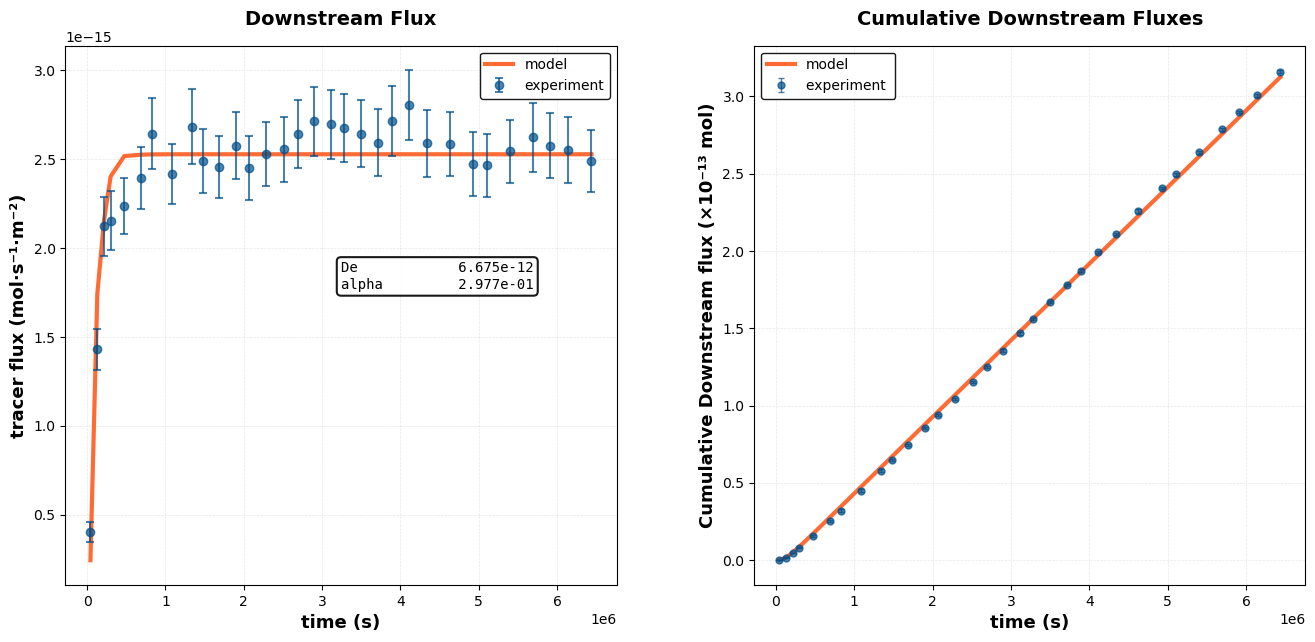

In [8]:
# =========================
# Diffusion Results Visualization
# =========================

class DiffusionPlotter:
    """Plot experimental data vs. model predictions."""

    def __init__(self, gui, fitter):
        """Store references and experiment mode."""
        self.gui = gui
        self.fitter = fitter
        self.mode = gui.mode
        
    # ---------- Out-diffusion ----------
    def plot_out_diffusion(self, figsize=(10, 7)):
        """Upstream/downstream flux vs time (log-y)."""
        t_hi, f_hi = self.gui.out_t_hi, self.gui.out_flux_hi
        t_lo, f_lo = self.gui.out_t_lo, self.gui.out_flux_lo

        p = self.fitter.result_ademodel.params
        alpha, De = p['alpha'].value, p['De'].value
        mod = self.fitter.flux_model(alpha=alpha, De=De)

        fig, ax = plt.subplots(figsize=figsize)

        ax.plot(t_hi, np.abs(f_hi), 'o', color='#FF6B35', ms=8, label='exp upstream', alpha=0.7, zorder=3)
        ax.plot(t_lo, np.abs(f_lo), 'o', color='#004E89', ms=8, label='exp downstream', alpha=0.7, zorder=3)

        ax.plot(mod.time, np.abs(mod.Upstream_flux), '-', color='#C1121F', lw=2.5, label='model upstream', zorder=2)
        ax.plot(mod.time, np.abs(mod.Downstream_flux), '-', color='#2D6A4F', lw=2.5, label='model downstream', zorder=2)

        ax.set_yscale('log')
        ax.set_xlabel('Time (s)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Flux (mol·s⁻¹·m⁻²)', fontsize=14, fontweight='bold')
        ax.set_title('Out-Diffusion: Flux vs Time', fontsize=16, fontweight='bold', pad=20)

        ax.grid(True, which='both', alpha=0.3, ls='--', lw=0.5)
        ax.legend(loc='best', fontsize=11, framealpha=0.9, edgecolor='black', fancybox=True)

        txt = f'De = {De:.3e} m²/s\nα = {alpha:.3f}'
        ax.text(0.02, 0.98, txt, transform=ax.transAxes, fontsize=11, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black'), family='monospace')

        plt.tight_layout()
        return fig, ax

    # ---------- Through-diffusion ----------
    def plot_Through_diffusion(self, figsize=(16, 7)):
        """Flux and integrated downstream flux vs time (two panels)."""
        t, f = self.fitter.tdat, self.fitter.fdat
        best_flux = self.fitter.best_flux
        best_integr = self.fitter.best_fit_integr
        alpha, De = self.fitter.best_alpha, self.fitter.best_De

        exp_integr = integrate.cumulative_trapezoid(y=f, x=t, initial=0.0) * self.fitter.cross_section_area  # mol

        fig = plt.figure(figsize=figsize)
        gs = GridSpec(1, 2, figure=fig, wspace=0.25)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        # Left: downstream flux
        ax1.errorbar(t, f, yerr=self.fitter.fdatU, fmt='o', color='#004E89', ms=6,
                     ecolor='#004E89', elinewidth=1.5, capsize=3, capthick=1.5,
                     label='experiment', alpha=0.7, zorder=3)
        ax1.plot(t, best_flux, '-', color='#FF6B35', lw=3, label='model', zorder=2)
        ax1.set_xlabel('time (s)', fontsize=13, fontweight='bold')
        ax1.set_ylabel('tracer flux (mol·s⁻¹·m⁻²)', fontsize=13, fontweight='bold')
        ax1.set_title('Downstream Flux', fontsize=14, fontweight='bold', pad=15)
        ax1.grid(True, alpha=0.3, ls='--', lw=0.5)
        ax1.legend(loc='best', fontsize=10, framealpha=0.9, edgecolor='black')
        ax1.text(0.50, 0.60, f'De            {De:.3e}\nalpha         {alpha:.3e}',
                 transform=ax1.transAxes, fontsize=10, va='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', lw=1.5),
                 family='monospace')

        # Right: integrated downstream flux (cumulative permeation)
        scale = 1e13
        ax2.errorbar(t, exp_integr * scale,
                     yerr=self.fitter.fdatU * np.gradient(t) * self.fitter.cross_section_area * scale,
                     fmt='o', color='#004E89', ms=5, ecolor='#004E89', elinewidth=1, capsize=2, capthick=1,
                     label='experiment ', alpha=0.7, zorder=3)
        ax2.plot(t, best_integr * scale, '-', color='#FF6B35', lw=3, label='model', zorder=2)
        ax2.set_xlabel('time (s)', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Cumulative Downstream flux (×10⁻¹³ mol)', fontsize=13, fontweight='bold')
        ax2.set_title('Cumulative Downstream Fluxes', fontsize=14, fontweight='bold', pad=15)
        ax2.grid(True, alpha=0.3, ls='--', lw=0.5)
        ax2.legend(loc='best', fontsize=10, framealpha=0.9, edgecolor='black')

        plt.tight_layout()
        return fig, (ax1, ax2)

    # ---------- Auto ----------
    def plot(self, figsize=None):
        """Dispatch by mode."""
        if self.mode == "out":
            return self.plot_out_diffusion(figsize or (10, 7))
        if self.mode == "Through":
            return self.plot_Through_diffusion(figsize or (16, 7))
        raise ValueError(f"Unknown mode: {self.mode}")

    def save_figure(self, filename, dpi=300, bbox_inches='tight'):
        """Generate and save current plot."""
        fig, _ = self.plot()
        fig.savefig(filename, dpi=dpi, bbox_inches=bbox_inches)
        plt.close(fig)


# ---------- Convenience ----------
def plot_results(gui, fitter, save_path=None):
    """One-call plotting; optionally save."""
    fig, ax = DiffusionPlotter(gui, fitter).plot()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig, ax

# Example (commented):
plotter = DiffusionPlotter(app, fitter)
fig, ax = plotter.plot()
plt.show()
# plot_results(app, fitter, save_path='diffusion_results.png')

### Reporting Functions
These functions generate a permanent, shareable record of an analysis run.

- **`generate_complete_report(gui_app, fitter, figure)`**:
    1.  Gathers the initial settings from the `DiffusionGUI` instance.
    2.  Captures the detailed numerical report from the `lmfit` result.
    3.  Converts the final `matplotlib` figure.
    4.  Assembles all three components into a single, standalone HTML file with a timestamped filename.
    5.  Saves the report to a `reports/` directory and updates an `index.html` file for easy navigation.


In [9]:


def _escape(s: str) -> str:
    """Simple HTML escape"""
    return html.escape(str(s), quote=False)

def _img_from_figure(fig, dpi=150):
    """Convert matplotlib figure to base64 PNG"""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=dpi)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode('utf-8')

def generate_complete_report(gui_app, fitter, figure):
    """
    Generate a standalone HTML report including:
      1) GUI initial parameters
      2) lmfit fitting report
      3) Result figure
    """
    reports_dir = Path("reports")
    reports_dir.mkdir(exist_ok=True)

    # --- 1. Initial settings ---
    state = gui_app._gather_state()
    settings_lines = [
        f"Experiment Mode: {state['mode'].upper()}",
        f"Data File: {state['file_path']}",
        f"Mesh File: {state['mesh_path']}",
        "",
        "--- Parameters ---"
    ]
    for k, v in state['params'].items():
        label = "alpha (initial guess)" if k == 'alpha' else "De (initial guess)" if k == 'De' else k
        settings_lines.append(f"{label:<24}: {v}")
    settings_html = "<h2>1. Initial Settings & Parameters</h2><pre>" + _escape("\n".join(settings_lines)) + "</pre>"

    # --- 2. Fitting results ---
    sbuf = io.StringIO()
    with contextlib.redirect_stdout(sbuf):
        lmfit.report_fit(fitter.result_ademodel)
    results_html = "<h2>2. Numerical Fitting Results</h2><pre>" + _escape(sbuf.getvalue()) + "</pre>"

    # --- 3. Plot image ---
    img_b64 = _img_from_figure(figure)
    plot_html = f'<h2>3. Results Visualization</h2><img src="data:image/png;base64,{img_b64}" style="max-width:100%;border:1px solid #ccc;"/>'

    # --- 4. Assemble and save HTML ---
    ts = datetime.datetime.now()
    title = f"Diffusion Experiment Report - {ts.strftime('%Y-%m-%d %H:%M:%S')}"
    html_doc = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<title>{_escape(title)}</title>
<style>
body {{ font-family:Segoe UI, Arial; margin:2em; line-height:1.6; color:#333; }}
h1, h2 {{ border-bottom:2px solid #eee; padding-bottom:8px; color:#005A9C; }}
pre {{ background:#f6f8fa; padding:16px; border-radius:6px; overflow:auto; border:1px solid #ddd; }}
img {{ margin-top:1em; }}
</style>
</head>
<body>
<h1>{_escape(title)}</h1>
{settings_html}
{results_html}
{plot_html}
</body>
</html>"""

    report_path = reports_dir / f"report-{ts.strftime('%Y%m%d-%H%M%S')}.html"
    report_path.write_text(html_doc, encoding="utf-8")    # --- 5. Update index.html ---
    runs = sorted(reports_dir.glob("report-*.html"), key=lambda p: p.stat().st_mtime, reverse=True)
    items = [f'<li><a href="{p.name}">{p.name}</a></li>' for p in runs]
    index_html = f'<!DOCTYPE html><html><head><meta charset="utf-8"><title>Reports</title></head><body><h1>Reports</h1><ul>{"".join(items)}</ul></body></html>'
    (reports_dir / "index.html").write_text(index_html, encoding="utf-8")

    return report_path

In [10]:

report_path = generate_complete_report(app, fitter, fig)
print("Report saved at:", report_path)


Report saved at: reports/report-20251126-090410.html



## Important Considerations and Best Practices

This GUI is designed to streamline the process of fitting diffusion models to experimental data. While it simplifies the workflow, the simplicity can mask the complexities of the underlying numerical model. Users should remain aware of these complexities to interpret results correctly and avoid potential pitfalls.

---

#### The "Stair-Step" Behavior in Plots

* **Observation**: You may notice that output curves, such as flux or concentration versus time, exhibit a "stair-step" or piecewise constant behavior.
* **Probable Cause**: This is often a plotting or solver artifact, not a physical phenomenon. It occurs when the time steps are too large to capture the smooth, continuous evolution of the system, especially right after a boundary condition changes.

* **Methods for Improvement and Verification**:
    * **Diagnostic Check (Code-level)**: For advanced users, investigating internal solver parameters (like a hypothetical **`update_flux`** flag) can help diagnose the issue. By modifying the code to set such a parameter to **`False`**, one could verify if the artifact is superficial and related to the solver's reporting mechanism rather than the core calculation.
    * **Advanced Time-Stepping Strategy**: The most critical moments in the simulation are immediately following a change in concentration or flux. A robust solution requires a **very fine-grained time-stepping scheme** specifically during these transient periods to accurately capture the rapid changes.

---

#### The Role of Tolerance (`tol`) and its Relation to Time Step (`dt`)

The "stair-step" issue is directly related to the time step (**`dt`**) size, which you control indirectly via the **`tol` (tolerance)** parameter. Understanding this relationship is key to balancing accuracy and performance.

* **What is `tol`**: The `tol` value represents the **maximum acceptable numerical error** for a single step in the simulation. It is the primary parameter you use to manage the trade-off between **calculation speed** and **numerical accuracy**. 
    * A **large `tol`** (e.g., `1e-3`) tells the solver you can "tolerate" a larger error. This allows for bigger time steps, leading to a **faster but less accurate** simulation. It's suitable for quick preliminary checks.
    * A **small `tol`** (e.g., `1e-6`) forces the solver to keep the error very small. This requires much smaller time steps, resulting in a **slower but more accurate** simulation with smoother curves. This is recommended for final results or publication-quality plots.

* **The `tol`-`dt` Relationship**: The solver uses an **adaptive time-stepping algorithm**. The **`dt`** value is not fixed; it changes dynamically based on the **`tol`** you set. The process works like this:
    1.  The solver attempts a calculation over a time step **`dt`**.
    2.  It estimates the error generated during that step.
    3.  **If `error > tol`**: The step is considered inaccurate. The solver **rejects the result, reduces `dt`**, and re-calculates. This happens automatically during periods of rapid change.
    4.  **If `error <= tol`**: The step is accepted, and the solver may try to increase `dt` for the next step to improve efficiency.

This adaptive mechanism is why a manual `dt` input was removed from the GUI. The initial `dt` value (1000 s) was merely a first guess for the algorithm, which immediately adjusts it based on the `tol` setting. **Therefore, `tol` is your actual control knob for the simulation's precision.**

---

### GUI Design Philosophy and Intended Use

It is important to understand what the GUI is—and is not—designed for.

* **Purpose**: The GUI excels at making standard, repetitive tasks easy and efficient. It intentionally hides dozens of underlying solver parameters to provide a clean, user-friendly interface for routine analysis.
* **Limitation**: By hiding this complexity, the GUI may prevent advanced users from having the fine-grained control needed for non-standard problems. A successful run does not guarantee that every underlying assumption of the model was perfectly met.

---

#### Recommended Usage by User Type

* **First-Time Users (with no coding experience)**: The GUI is the ideal tool for routine analysis where the primary goal is to obtain best-fit parameters (**`De`**, **`alpha`**) from a standard through- or out-diffusion experiment. The GUI serves as an excellent tool for a quick "sanity check" or a first-pass analysis to ensure results are in a reasonable range before proceeding with more detailed work.
* **For Advanced Users & Researchers**: The GUI should be viewed as a template or starting point. For cases involving other boundary conditions (e.g., filters), additional physical processes, or detailed investigations of curve shapes, use the GUI to define the basic problem setup and then switch to direct interaction with the underlying Python objects (app, fitter, problem) for full control and customization. Experts are encouraged to use the **Programmers Information on the Numerical toolbox** for deeper insights into numerical implementation details.

---

### General Troubleshooting and Advice

* **Critically Evaluate Your Results**: If a fit looks strange or a curve seems non-physical, it probably is. Trust your scientific intuition and investigate further rather than blindly trusting the output.
* **Check for Convergence Issues**: If the fitting process fails or produces unreasonable parameters, try running it again with **different initial guesses for `alpha` and `De`**. The optimization algorithm can sometimes get stuck in a local minimum.
* **Validate the Model's Applicability**: Always ask: "Is the simple 1D diffusion model appropriate for my specific material and experimental setup?" The tool performs the numerical calculation correctly, but it is the **user's responsibility** to ensure the chosen model is scientifically valid for their problem.
